# Primo prototipo di modello ML: decision tree

Liberie varie da installare

In [57]:
#!pip install pandas
#!pip install sklearn
#!pip install seaborn
#!pip install imblearn

Inclusione delle librerie utilizzate

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

Variabili di gestione files

In [59]:
# Path of the dataset in .pkl format, can be changed
PATH_DATASET = r"C:\Users\Andre\OneDrive - Università degli Studi di Parma\Tirocinio\Dataset_output\filtered_active_bankruptcy_small.pkl"

# True = Standardize data, can be changed
to_standardize = False

# True = Oversample the least populated class (Bankruptcy), can be changed
avoid_imbalanced_training = True

# Select a random state value in order to control the randomness effect, can be changed
rnd_state = 25

Lettura del dataset

In [60]:
dataset = pd.read_pickle(PATH_DATASET)
print("Il dataset da utilizzare ha", dataset.shape[0], "record e", dataset.shape[1], "colonne")

Il dataset da utilizzare ha 646468 record e 21 colonne


Suddivisione del dataset in X e Y, dove X sono le features in ingresso (indicatori finanziari) e Y è la risposta in output (attivo/bancarotta)

In [61]:
X_features_names = ['PN/Totale Debiti',
                    'Deb. Prev + Trib/Attivo',
                    'Tempo medio riscossione (TMR)',
                    'Tempo medio di pagamento (TMP)',
                    'PFN/EBITDA',
                    'PFN/PN',
                    'Gearing',
                    'ROS',
                    'Working capital/net sales',
                    'Cash/Current Liabilities',
                    'Accounts receivable/inventory',
                    'EBIT/interest expenses',
                    'Att.Br/Attivo',
                    'Ricavi/Attivo',
                    'EBITDA/Totale Debiti']

Y_feature_name = 'Legal Status'

X_dataset = dataset[X_features_names].copy()
Y_dataset = dataset[Y_feature_name].copy()

Stampo i primi record dei 2 nuovi dataset per chiarezza

In [62]:
X_dataset.head()

,PN/Totale Debiti,Deb. Prev + Trib/Attivo,Tempo medio riscossione (TMR),Tempo medio di pagamento (TMP),PFN/EBITDA,PFN/PN,Gearing,ROS,Working capital/net sales,Cash/Current Liabilities,Accounts receivable/inventory,EBIT/interest expenses,Att.Br/Attivo,Ricavi/Attivo,EBITDA/Totale Debiti
0,0.062759,0.018469,132.395004,75.595004,4.934119,10.264500,0.911226,0.083199,0.775917,0.090424,1.128547,3.595384,0.894619,1.152983,0.130558
1,0.004904,0.000047,5.730942,2083.270723,-179.934494,174.011292,0.994286,-0.377653,79.832063,0.009702,0.000200,-5053.000000,0.997454,0.012494,-0.004743
2,0.210145,0.012336,59.357925,80.109660,9.836861,3.533378,0.779414,0.071155,0.322540,0.004904,2.418841,1.184761,0.212252,0.658064,0.075484
3,0.066812,0.032663,147.727157,124.675919,-9.566669,7.865999,0.887210,-0.094270,0.678891,0.000062,1.716560,-18.549697,0.846830,1.247374,-0.054935
4,0.089686,0.000443,0.000000,37.485829,-5.902348,10.710084,0.914604,-0.125769,0.823316,0.126618,0.000000,-5.055620,0.991318,1.204055,-0.162739


In [63]:
Y_dataset.head()

0    Active
1    Active
2    Active
3    Active
4    Active
Name: Legal Status, dtype: object

Codifico la variabile di risposta (Active/Bankruptcy) in (0/1)

In [64]:
Y_dataset.replace({"Active": 0, "Bankruptcy": 1}, inplace=True)
Y_dataset.head()

0    0
1    0
2    0
3    0
4    0
Name: Legal Status, dtype: int64

Controllo il numero di record per ciascuna classe

In [65]:
Y_dataset.value_counts()

0    439646
1    206822
Name: Legal Status, dtype: int64

Uso la tecnica di random oversampling per evitare un allenamento di un modello con classi sbilanciate

In [66]:
if avoid_imbalanced_training:
    sm = SMOTE(random_state=rnd_state)
    X_dataset, Y_dataset = sm.fit_resample(X_dataset, Y_dataset)
Y_dataset.value_counts()

0    439646
1    439646
Name: Legal Status, dtype: int64

Standardizzo i dati contenuti in X

In [67]:
if to_standardize:
    scaler = StandardScaler()
    X_dataset = scaler.fit_transform(X_dataset)

Divido i 2 dataset in train e test

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dataset, Y_dataset, stratify=Y_dataset, test_size=0.30, random_state=rnd_state)

Creo primo prototipo di decision tree e lo alleno sui dati di train

In [69]:
decision_tree_classifier = tree.DecisionTreeClassifier()
decision_tree_classifier.fit(X_train, Y_train)

DecisionTreeClassifier()

Guardo come si comporta sui dati di test che il modello non ha mai visto

In [70]:
Y_predicted = decision_tree_classifier.predict(X_test)
score = accuracy_score(Y_test, Y_predicted)
print("L'accuratezza è", score)

L'accuratezza è 0.7584385946290203


[Text(0, 0.5, 'Active'), Text(0, 1.5, 'Bankruptcy')]

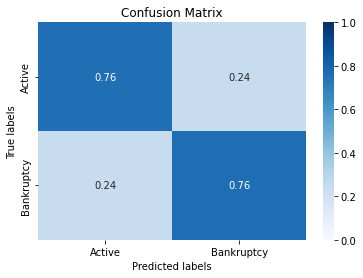

In [71]:
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_predicted)
conf_matrix = conf_matrix / conf_matrix.astype(np.float64).sum(axis=1)

ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, vmin=0.0, vmax=1.0, fmt=".2f", cmap="Blues", ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Active', 'Bankruptcy'])
ax.yaxis.set_ticklabels(['Active', 'Bankruptcy'])

Provo utilizzando la tecnica del cross-validation score

In [72]:
# prepare the cross-validation procedure
cv = KFold(n_splits=20, random_state=rnd_state, shuffle=True)
# create model
decision_tree_classifier_cv = tree.DecisionTreeClassifier()
# evaluate model
scores = cross_val_score(decision_tree_classifier_cv, X_dataset, Y_dataset, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print("L'accuratezza è", np.mean(scores))

L'accuratezza è 0.771359241429536


Stampo in formato testuale il decision tree

In [73]:
text_representation = tree.export_text(decision_tree_classifier, feature_names=X_features_names)
print(text_representation)

|--- Tempo medio di pagamento (TMP) <= 0.00
|   |--- Deb. Prev + Trib/Attivo <= 0.00
|   |   |--- PFN/EBITDA <= 8.06
|   |   |   |--- Cash/Current Liabilities <= 2.50
|   |   |   |   |--- PFN/EBITDA <= -24.66
|   |   |   |   |   |--- EBITDA/Totale Debiti <= -0.00
|   |   |   |   |   |   |--- Working capital/net sales <= 4.02
|   |   |   |   |   |   |   |--- Tempo medio riscossione (TMR) <= 189.79
|   |   |   |   |   |   |   |   |--- Accounts receivable/inventory <= 8.38
|   |   |   |   |   |   |   |   |   |--- Att.Br/Attivo <= 1.00
|   |   |   |   |   |   |   |   |   |   |--- PN/Totale Debiti <= 0.08
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- PN/Totale Debiti >  0.08
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |--- Att.Br/Attivo >  1.00
|   |   |   |   |   |   |   |   |   |   |--- PFN/EBITDA <= -320.77
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1